## WGU D209: Data Mining I
### Task 1: Classification Analysis

#### Data Acquisition

In [6]:
# Import the standard libraries.

# Import and configure Pandas.
import pandas as pd
pd.set_option('display.precision',3)
pd.set_option('display.max_columns',9)
pd.set_option('display.width', None)

# Import and configure Scientific Computing.
import numpy as np
import scipy.stats as stats
import scipy

# Import and configure plotting packages.
import graphviz
import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Warnings
import warnings

In [7]:
# Import and configure SciKit Learn.

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, _tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import export_graphviz as dt # decisiontree
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
# Load the CSV file.
df = pd.read_csv('/Users/jillrivera/Documents/WGU/209 Data Mining I/Churn/churn_clean.csv')
df.head()

,CaseOrder,Customer_id,Interaction,UID,...,Item5,Item6,Item7,Item8
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,...,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,...,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,...,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,...,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,...,4,4,4,5


In [14]:
df.columns

Index(['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
       'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
       'Children', 'Age', 'Income', 'Marital', 'Gender', 'Churn',
       'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure',
       'Techie', 'Contract', 'Port_modem', 'Tablet', 'InternetService',
       'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'Tenure', 'MonthlyCharge',
       'Bandwidth_GB_Year', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5',
       'Item6', 'Item7', 'Item8'],
      dtype='object')

In [15]:
df.shape

(10000, 50)

#### Data Cleaning

In [17]:
# Create a data frame using only the variables for this analysis.
raw = df[['Churn', 'Tenure', 'MonthlyCharge']].copy()
raw.head()

,Churn,Tenure,MonthlyCharge
0,No,6.796,172.456
1,Yes,1.157,242.633
2,No,15.754,159.948
3,No,17.087,119.957
4,Yes,1.671,149.948


In [18]:
# Check for null values.
raw.isnull().sum()

Churn            0
Tenure           0
MonthlyCharge    0
dtype: int64

In [19]:
# Check for duplicated rows.
raw.duplicated().any()

False

In [21]:
# Check for outlying values in the numerical data using z-score.

raw_numerical = raw.select_dtypes(exclude = 'object')
z_scores = stats.zscore(raw_numerical)
abs_z_scores = np.abs(z_scores)
filtered_scores = (abs_z_scores < 3).all(axis = 1)
raw_wo_outliers = raw[filtered_scores]
raw_wo_outliers.shape

(10000, 3)

In [24]:
# Rename the cleaned data set.
clean = raw_wo_outliers.copy()
clean.head()

,Churn,Tenure,MonthlyCharge
0,No,6.796,172.456
1,Yes,1.157,242.633
2,No,15.754,159.948
3,No,17.087,119.957
4,Yes,1.671,149.948


#### Data Exploration

In [25]:
# Variable statistics of the numerical data.
clean.describe()

,Tenure,MonthlyCharge
count,10000.000,10000.000
mean,34.526,172.625
std,26.443,42.943
min,1.000,79.979
25%,7.918,139.979
50%,35.431,167.485
75%,61.480,200.735
max,71.999,290.160


In [26]:
# Show the variables to be analyzed.

for c in clean.loc[:, clean.columns]:
    if clean.dtypes[c] == "object":
        print('\n{} is categorical: {}.'.format(c,clean[c].unique()))
    else:
        print('\n{} is numerical:'.format(c ))
        print('\trange = {} - {}'.format(clean[c].min(),clean[c].max()))
        print('\tmean = {:.2f} +/- {:.2f}'.format(clean[c].mean(), clean[c].std()))


Churn is categorical: ['No' 'Yes'].

Tenure is numerical:
	range = 1.00025934 - 71.99928
	mean = 34.53 +/- 26.44

MonthlyCharge is numerical:
	range = 79.97886 - 290.160419
	mean = 172.62 +/- 42.94


No     7350
Yes    2650
Name: Churn, dtype: int64


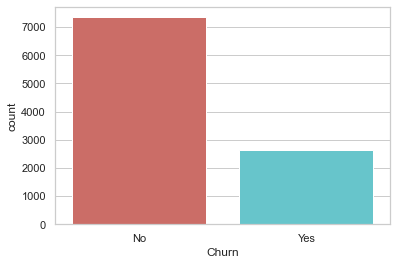

In [28]:
# Explore the churn variable. 

print(clean['Churn'].value_counts())
sns.countplot(x='Churn', data=clean, palette='hls')
plt.show()

In [29]:
# Calculate the numerical mean data compared to churn.

clean.groupby('Churn').mean().round(2).T

Churn,No,Yes
Tenure,42.23,13.15
MonthlyCharge,163.01,199.30


#### Data Wrangling

In [30]:
# Convert churn values from yes/no to true/false.

target = 'Churn'
clean[target] = clean[target].replace({"No": False, "Yes": True})
clean[target] = clean[target].astype('bool')

In [31]:
# Scale the numerical variables.

features = ['MonthlyCharge', 'Tenure']
for c in features:
    clean['z'+c] = (clean[c] - clean[c].mean()) / clean[c].std()

In [32]:
# Show the clean data set for analysis.

def describeData(data):
    for idx, c in enumerate(data.columns):
        if data.dtypes[c] in ('float', 'int', 'int64'):
            print('\n{}. {} is numerical (CONTINUOUS) - type: {}.'.format(idx+1, c, data.dtypes[c]))
            if data.dtypes[c] in ('int', 'int64'):
                numbers = data[c].to_numpy()
                print('  Unique: {}'.format(get_unique_numbers(numbers)))
            if data.dtypes[c] in ('float', 'float64'):
                print('  Min: {:.3f}  Max: {:.3f}  Std: {:.3f}'.format(data[c].min(), data[c].max(),data[c]
                                                                       .std()))
        elif data.dtypes[c] == bool:
            print('\n{}. {} is boolean (BINARY): {}.'.format(idx+1,c,data[c].unique()))
        else:
            print('\n{}. {} is categorical (CATEGORICAL): {}.'.format(idx+1,c,data[c].unique()))
            
describeData(data = clean)


1. Churn is boolean (BINARY): [False  True].

2. Tenure is numerical (CONTINUOUS) - type: float64.
  Min: 1.000  Max: 71.999  Std: 26.443

3. MonthlyCharge is numerical (CONTINUOUS) - type: float64.
  Min: 79.979  Max: 290.160  Std: 42.943

4. zMonthlyCharge is numerical (CONTINUOUS) - type: float64.
  Min: -2.157  Max: 2.737  Std: 1.000

5. zTenure is numerical (CONTINUOUS) - type: float64.
  Min: -1.268  Max: 1.417  Std: 1.000


#### Export the clean data set.

In [33]:
# Export the cleaned data set to a CSV file. 
clean.to_csv('209clean_task1.csv')

### Analysis

#### Training and testing split of the data.

In [34]:
# Define the primary feature and target data.

target= 'Churn' # target data
X = clean.loc[:, clean.columns != target]
y = clean.loc[:, clean.columns == target]

In [35]:
# Train / Test split the raw data.

tts = train_test_split(X, y, test_size=0.3, random_state=13)
(X_train, X_test, y_train, y_test)=tts
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (7000, 4)
y_train: (7000, 1)
X_test: (3000, 4)
y_test: (3000, 1)


In [38]:
# Label the training data and export a copy to a CSV file.

trainData = X_train.merge(y_train, 
        left_index=True, right_index=True)
trainData.to_csv('209trainData_task1.csv')

In [39]:
# Label the test data and export a copy to a CSV file.

testData = X_test.merge(y_test, 
        left_index=True, right_index=True)
testData.to_csv('209testData_task1.csv')

#### Define the new customer 

In [40]:
# Create the new customer that will be used for the analysis.

newCustomer = pd.DataFrame([{'Tenure': 1.0, 'MonthlyCharge': 175.0, 'zTenure': 0.0, 'zMonthlyCharge': 0.0}])

<AxesSubplot:xlabel='MonthlyCharge', ylabel='Tenure'>

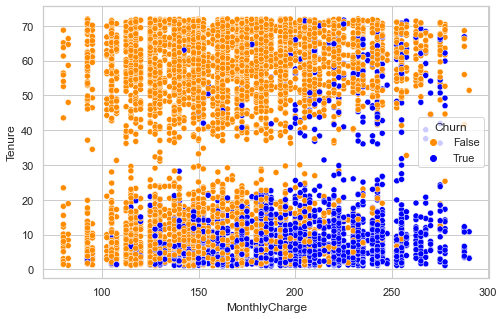

In [41]:
# Scatter plot of Monthly Charge vs Tenure using the training set.

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.scatterplot(x='MonthlyCharge',y='Tenure',
    palette=['darkorange','blue'], hue=target,
    data=y_train.merge(X_train, left_index=True, right_index=True))

Text(0, -0.4, '   Tenure  MonthlyCharge  zTenure  zMonthlyCharge\n0     1.0          175.0      0.0             0.0')

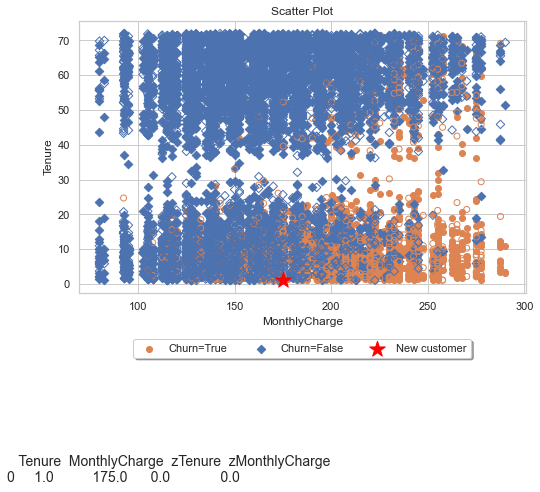

In [42]:
# Scatter plot using the testing data set.

xFeature = 'MonthlyCharge' 
yFeature = 'Tenure'
target = 'Churn'
neighbors = []

def plotDataset(ax, data, xFeature, yFeature, target, neighbors, showLabel=True, **kwargs):
    
    """plot a given dataset with the target data on a given axis
    """
    # Churn == True
    subset = data.loc[data[target]==True]
    ax.scatter(subset[xFeature], subset[yFeature], marker='o',
              label=str(target)+'=True' if showLabel else None, color='C1', **kwargs)
    
    # Churn == False
    subset = data.loc[data[target]==False]
    ax.scatter(subset[xFeature], subset[yFeature], marker='D',
              label=str(target)+'=False' if showLabel else None, color='C0', **kwargs)
    
    # labels
    if len(neighbors) > 0:
        for idx, row in data.iterrows():
            ax.annotate(str(idx), (row[xFeature], row[yFeature])) 

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotDataset(ax, trainData, xFeature, yFeature, target, neighbors)
plotDataset(ax, testData, xFeature, yFeature, target, neighbors, showLabel=False, facecolors='none')

# Plot the new customer as a star.
ax.scatter(newCustomer.MonthlyCharge, newCustomer.Tenure, marker='*',
          label='New customer', color='red', s=270)

title = 'Scatter Plot'
plt.title(title)
plt.xlabel(xFeature) 
plt.ylabel(yFeature)

# Configure the legend.
handles, labels = ax.get_legend_handles_labels()
patch = mpatches.Patch(color='grey', label='Manual Label')
handles.append(patch) 
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)

# Add the new customer data text.
plt.gcf().text(0, -.4, newCustomer.to_string(), fontsize=14)

#### Create the model.

In [43]:
# KNN Model
knn = KNeighborsClassifier()
knn.fit(X = X_train, y = y_train['Churn'])

KNeighborsClassifier()

In [44]:
# Predicted Data
predicted = knn.predict(X=X_test)

In [45]:
# Observed Data
observed = y_test['Churn']

In [48]:
# Incorrectly predicted data.

wrong = [(p,e) for (p,e) in zip(predicted, observed) if p!=e]
len(wrong)

523

In [49]:
# Calculate the KNN score for the model.

knn.score(X_test, y_test)

0.8256666666666667

In [50]:
# Run Hyperparameter Tuning on the model.

for k in range(1,40,2):
    kfold = KFold(n_splits=10, random_state=11, shuffle=True)
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(estimator=knn,
            X=X_train, y=y_train['Churn'], cv=kfold)
    print(f'k={k:<2}; mean accuracy={scores.mean():.2%};')

k=1 ; mean accuracy=78.53%;
k=3 ; mean accuracy=81.49%;
k=5 ; mean accuracy=81.53%;
k=7 ; mean accuracy=82.30%;
k=9 ; mean accuracy=82.39%;
k=11; mean accuracy=82.64%;
k=13; mean accuracy=82.69%;
k=15; mean accuracy=82.97%;
k=17; mean accuracy=83.06%;
k=19; mean accuracy=82.96%;
k=21; mean accuracy=83.26%;
k=23; mean accuracy=83.21%;
k=25; mean accuracy=83.24%;
k=27; mean accuracy=83.19%;
k=29; mean accuracy=83.33%;
k=31; mean accuracy=83.29%;
k=33; mean accuracy=83.27%;
k=35; mean accuracy=83.30%;
k=37; mean accuracy=83.57%;
k=39; mean accuracy=83.66%;


In [51]:
# Scale the new customer data.

newCustomer['zMonthlyCharge'] = (newCustomer['MonthlyCharge'] - clean['MonthlyCharge'].mean() ) / 
                                clean['MonthlyCharge'].std()
newCustomer['zTenure'] =  (newCustomer['Tenure'] - clean['Tenure'].mean() ) / clean['Tenure'].std()
newCustomerNorm = newCustomer[['zTenure','zMonthlyCharge']]
newCustomerNorm

,zTenure,zMonthlyCharge
0,-1.268,0.055


In [53]:
# Use NearestNeighbors from SciKit-Learn to compute KNN.

k=7 # Determined from the hyperparameter tuning.
knn = NearestNeighbors(n_neighbors=k)
knn.fit(trainData.iloc[:,3:5])
distances, indices = knn.kneighbors(newCustomerNorm)
training_neighbors = trainData.iloc[indices[0],:]

# Show the training neighbors.
d = training_neighbors
display(d)

/Users/jillrivera/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- zMonthlyCharge
Feature names seen at fit time, yet now missing:
- Churn

  warnings.warn(message, FutureWarning)


,Tenure,MonthlyCharge,zMonthlyCharge,zTenure,Churn
3359,1.035,127.496,-1.051,-1.267,False
947,1.047,144.961,-0.644,-1.266,False
2759,1.050,157.470,-0.353,-1.266,False
3009,1.125,169.993,-0.061,-1.263,False
823,1.128,212.641,0.932,-1.263,False
4254,1.140,127.525,-1.050,-1.263,False
4396,1.150,164.971,-0.178,-1.262,False


In [54]:
# Re-train the model with all data.

k=7
knn = KNeighborsClassifier(n_neighbors=k).fit(X[['zTenure','zMonthlyCharge']], y['Churn'])
distances, indices = knn.kneighbors(newCustomerNorm)
print('Churn prediction (k={}) for \n{} is \n{}'.format(k,newCustomer,knn.predict(newCustomerNorm)))
df_neighbors = clean.iloc[indices[0],:]
neighbors = df_neighbors.index
neighbors = neighbors.to_list()
print(df_neighbors)

Churn prediction (k=7) for 
   Tenure  MonthlyCharge  zTenure  zMonthlyCharge
0     1.0          175.0   -1.268           0.055 is 
[ True]
      Churn  Tenure  MonthlyCharge  zMonthlyCharge  zTenure
4283   True   1.523        174.988           0.055   -1.248
2366   True   1.583        174.970           0.055   -1.246
3259  False   1.611        174.976           0.055   -1.245
709    True   1.725        174.976           0.055   -1.240
2580   True   1.794        174.977           0.055   -1.238
3261   True   1.916        174.962           0.054   -1.233
582   False   2.140        175.006           0.055   -1.225


#### Final prediction scatter plot with neighbors

In [55]:
# Function to construct file names for figures and tables.
def getFilename(title: str, caption: str,
             sect='XX', ftype = 'PNG',
            course = 'D209', task = 'TASK1',
               subfolder='figures') -> str:
    """
    Construct a filename for given figure or table
    Input:
      title:
      sect:
      caption:
      ftype:
      course:
      task:
      subfolder:
    """
    temp = subfolder + '/'  # subfolder for tables and figures, default is 'fig'
    temp += course + '_'
    temp += task + '_'
    temp += sect + '_'
    temp += subfolder[0:3] + " " +caption + '_' #
    temp += title
    temp += '.' + ftype

    return temp.replace(' ','_').upper()

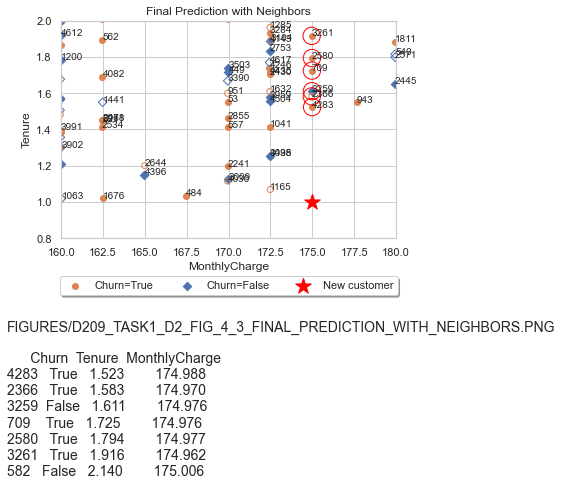

In [61]:
# Scatter plot using the plotDataset function
xFeature = 'MonthlyCharge' 
yFeature = 'Tenure'
fig, ax = plt.subplots()
plotDataset(ax, trainData, xFeature, yFeature, target, neighbors)
plotDataset(ax, testData, xFeature, yFeature, target, neighbors, showLabel=False, facecolors='none')

# Plot the new customer as a star.
ax.scatter(newCustomer.MonthlyCharge, newCustomer.Tenure, marker='*',
          label='New customer', color='red', s=270)

# Highlight neighbors with red circles.
if len(neighbors) > 0:
    for n in neighbors:
        point = clean.iloc[n]
        ax.scatter(point.MonthlyCharge, point.Tenure, marker='o',
                color='red', s=300, facecolors='none')

title = 'Final Prediction with Neighbors'
plt.title(title)
plt.xlabel(xFeature) 
plt.ylabel(yFeature)

# Set axis limits centered around the new customer.
left = float(newCustomer.MonthlyCharge) - 4
right = float(newCustomer.MonthlyCharge) + 4
top = float(newCustomer.Tenure) - 4
bottom = float(newCustomer.Tenure) + 3
ax.set_xlim(160,180)
ax.set_ylim(.8,2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
f = getFilename(title, sect='d2',
        subfolder='figures', caption='4 3') # getFilename using helper
plt.gcf().text(0, -.2, f, fontsize=14) 

# Loop through the neighbors and include neighbors as table data.
plt.gcf().text(0, -.7, df_neighbors.iloc[:, 0:3].to_string(), fontsize=14)     
plt.show()

#### Confusion Matrix

Text(0, -0.9, 'Correct Predictions (COR): 2477')

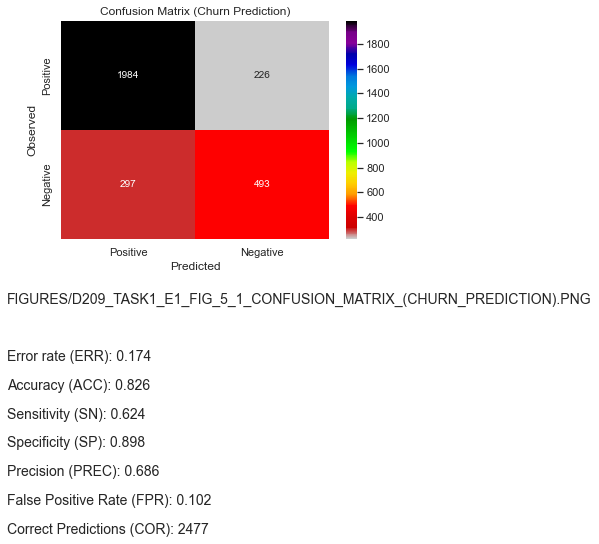

In [57]:
# Create the confusion matrix.
confusion = confusion_matrix(y_true=observed, y_pred=predicted)

# Create the plot.
fig, ax = plt.subplots()
ax = sns.heatmap(confusion, annot=True,
            cmap='nipy_spectral_r', fmt='d')
title = 'Confusion Matrix (Churn Prediction)'
plt.title(title)
ax.set_xlabel('Predicted');
ax.set_ylabel('Observed'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']);
ax.yaxis.set_ticklabels(['Positive', 'Negative']);

# Add a filename.
f = getFilename(title, sect='E1',
                subfolder='figures', caption='5 1') 
plt.gcf().text(0, -.1, f, fontsize=14) 

# Add measurements.
TN, FP, FN, TP = confusion_matrix(y_true=observed, y_pred=predicted).ravel()
P = TP + FP
N = TN + FN
ERR = (FP + FN) / (TP + TN + FN + FP) # Error rate
ACC = (TP + TN) / (TP + TN + FN + FP) # Accuracy
SN = TP / (TP + FN) # Sensitivity
SP = TN / (TN + FP) # Specificity
PREC = TP / (TP + FP) # Precision
FPR = FP / (TN + FP) # False Positive Rate
COR = TP + TN

plt.gcf().text(0, -.3, 'Error rate (ERR): ' + str(ERR.round(3)), fontsize=14) 
plt.gcf().text(0, -.4, 'Accuracy (ACC): ' + str(ACC.round(3)), fontsize=14) 
plt.gcf().text(0, -.5, 'Sensitivity (SN): ' + str(SN.round(3)), fontsize=14) 
plt.gcf().text(0, -.6, 'Specificity (SP): ' + str(SP.round(3)), fontsize=14) 
plt.gcf().text(0, -.7, 'Precision (PREC): ' + str(PREC.round(3)), fontsize=14) 
plt.gcf().text(0, -.8, 'False Positive Rate (FPR): ' + str(FPR.round(3)), fontsize=14)  
plt.gcf().text(0, -.9, 'Correct Predictions (COR): ' + str(COR.round(3)), fontsize=14) 

#### Receiver Operating Characteristic (ROC)

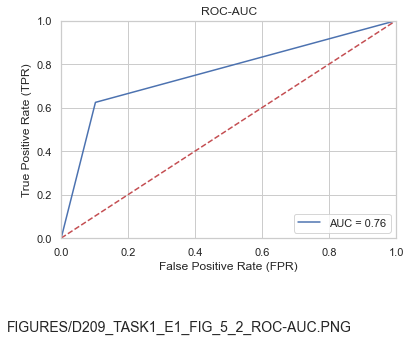

In [58]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification.
fpr, tpr, threshold = metrics.roc_curve(observed, predicted)
auc = metrics.auc(fpr, tpr)

# Method I: Plot
fig, ax = plt.subplots()
title = 'ROC-AUC'
plt.title(title)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
f = getFilename(title, sect='e1',
    subfolder='figures', caption='5 2') # getFilename
plt.gcf().text(0, -.2, f, fontsize=14) 
plt.show()